In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np

# Step 1: Load the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.5)
X_images = lfw_people.images  # shape (n_samples, height, width)
y = lfw_people.target
target_names = lfw_people.target_names


In [2]:
print("Total samples:", len(X_images))
print("Image shape:", X_images[0].shape)
print("Number of unique people:", len(target_names))
print("Target names:", target_names)

# Count images per person
from collections import Counter
count_by_label = Counter(y)
for idx, count in count_by_label.items():
    print(f"{target_names[idx]}: {count} images")


Total samples: 1560
Image shape: (62, 47)
Number of unique people: 12
Target names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']
Tony Blair: 144 images
Gerhard Schroeder: 109 images
Donald Rumsfeld: 121 images
George W Bush: 530 images
Colin Powell: 236 images
Ariel Sharon: 77 images
Serena Williams: 52 images
John Ashcroft: 53 images
Hugo Chavez: 71 images
Jean Chretien: 55 images
Junichiro Koizumi: 60 images
Jacques Chirac: 52 images


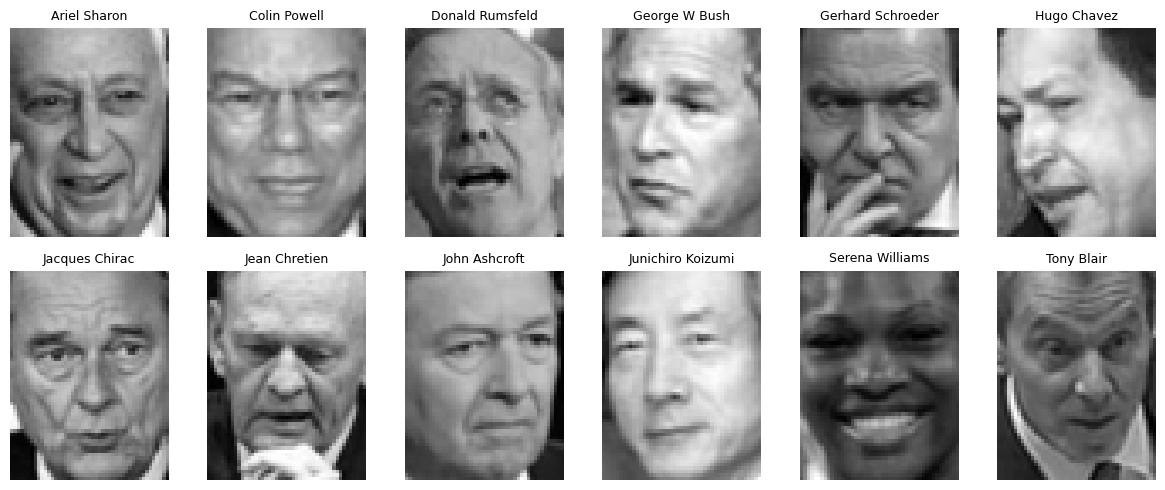

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique class indices
unique_classes = np.unique(y)

# Select one image per class
images = []
labels = []
for class_idx in unique_classes:
    idx = np.where(y == class_idx)[0][0]  # first image of that class
    images.append(X_images[idx])
    labels.append(target_names[class_idx])

# Plot the 12 images (2x6)
fig, axes = plt.subplots(2, 6, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(labels[i], fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()


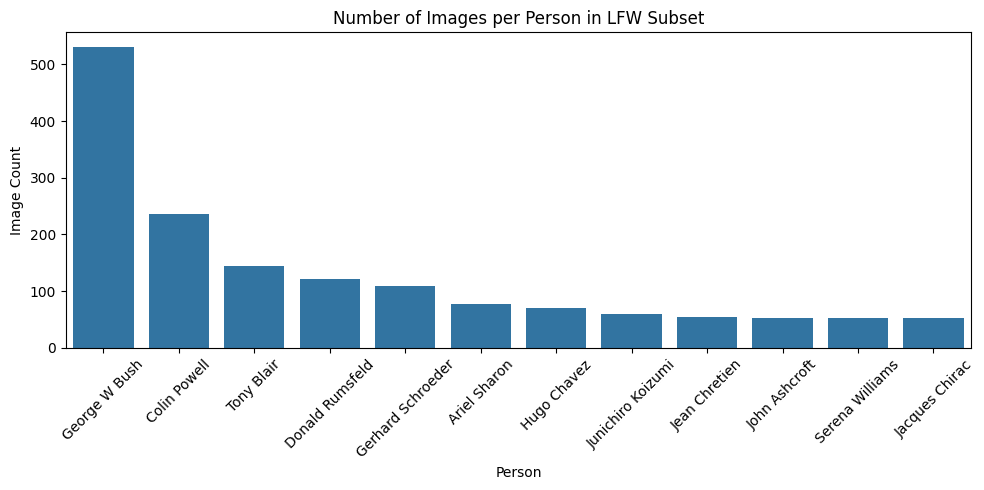

In [4]:
import seaborn as sns
import pandas as pd

# Convert count info to DataFrame for plotting
person_counts = pd.DataFrame({
    'Person': [target_names[i] for i in count_by_label.keys()],
    'Image Count': list(count_by_label.values())
}).sort_values(by="Image Count", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=person_counts, x="Person", y="Image Count")
plt.xticks(rotation=45)
plt.title("Number of Images per Person in LFW Subset")
plt.tight_layout()
plt.show()


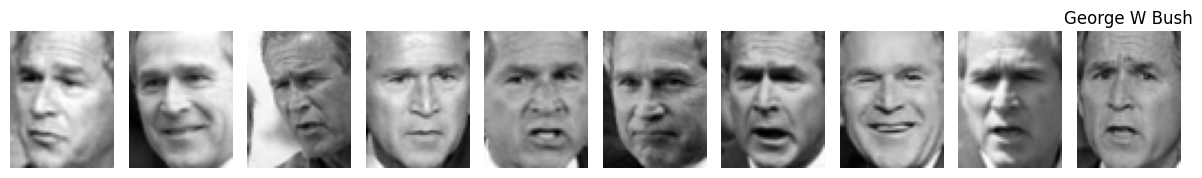

In [5]:
# Get images of "George W Bush"
person_name = "George W Bush"
person_index = list(target_names).index(person_name)

# Filter images
bush_images = X_images[y == person_index]

# Show 10 images of Bush
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(bush_images[i], cmap='gray')
    ax.axis('off')
ax.set_title(person_name)
plt.tight_layout()
plt.show()


In [6]:
from skimage.feature import hog
from skimage.transform import resize
import numpy as np
from tqdm import tqdm
import time

hog_features = []
hog_images = []  # For optional visualization

start_time = time.time()

for image in tqdm(X_images, desc="Extracting HOG features"):
    resized_img = resize(image, (64, 64), anti_aliasing=True)  # Consistent size
    features, hog_image = hog(resized_img,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              block_norm='L2-Hys',
                              visualize=True)
    hog_features.append(features)
    hog_images.append(hog_image)

X_hog = np.array(hog_features)
print("HOG feature matrix shape:", X_hog.shape)
print("Time taken: %.2f seconds" % (time.time() - start_time))


Extracting HOG features: 100%|█████████████████████████████████████████████████████| 1560/1560 [00:50<00:00, 30.83it/s]

HOG feature matrix shape: (1560, 1764)
Time taken: 50.61 seconds


In [7]:
print("Each image is now represented by", X_hog.shape[1], "features")

Each image is now represented by 1764 features


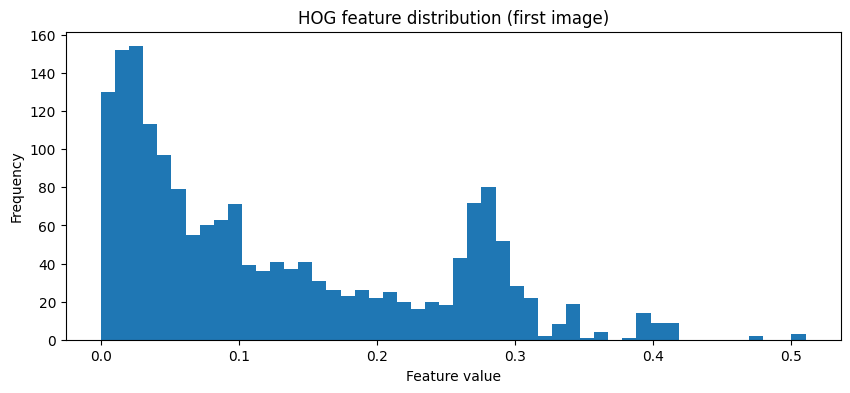

              0            1            2            3            4     \
count  1560.000000  1560.000000  1560.000000  1560.000000  1560.000000   
mean      0.271451     0.230064     0.171118     0.092280     0.164345   
std       0.082782     0.113040     0.116540     0.094243     0.088186   
min       0.004948     0.000000     0.000000     0.000000     0.002593   
25%       0.246590     0.138378     0.061164     0.017440     0.094708   
50%       0.282131     0.267438     0.164540     0.056780     0.160026   
75%       0.321216     0.313383     0.277211     0.142424     0.238479   
max       0.506654     0.467147     0.514370     0.425828     0.425828   

              5            6            7            8            9     ...  \
count  1560.000000  1560.000000  1560.000000  1560.000000  1560.000000  ...   
mean      0.045856     0.052846     0.075651     0.129640     0.216304  ...   
std       0.062330     0.065435     0.077233     0.103266     0.082944  ...   
min       0.00000

In [8]:
import matplotlib.pyplot as plt

# Distribution of feature values
plt.figure(figsize=(10, 4))
plt.hist(X_hog[0], bins=50)
plt.title("HOG feature distribution (first image)")
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.show()

# Summary stats
import pandas as pd
hog_df = pd.DataFrame(X_hog)
print(hog_df.describe())


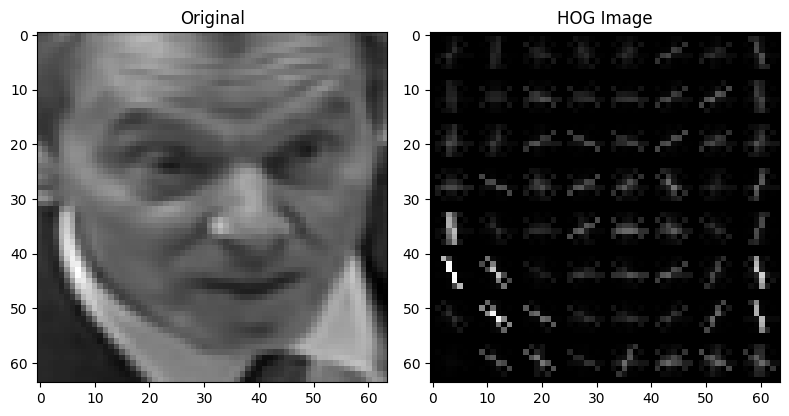

In [9]:
# Visualize HOG of a sample
idx = 0
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(resize(X_images[idx], (64, 64)), cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(hog_images[idx], cmap='gray')
plt.title("HOG Image")
plt.tight_layout()
plt.show()


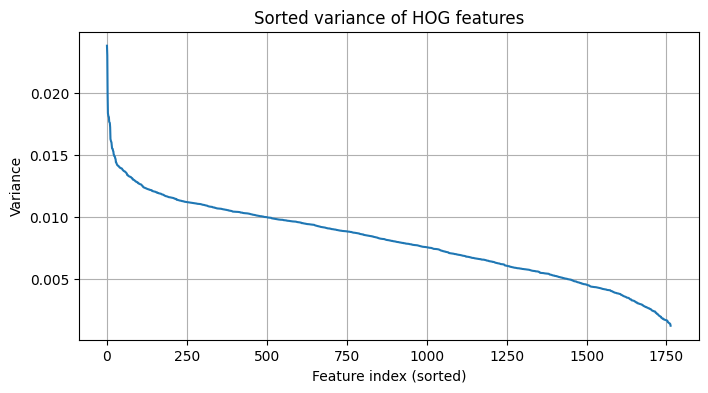

In [10]:
variances = np.var(X_hog, axis=0)
top_features = np.argsort(variances)[-10:]  # indices of top 10 varying features

plt.figure(figsize=(8, 4))
plt.plot(sorted(variances, reverse=True))
plt.title("Sorted variance of HOG features")
plt.xlabel("Feature index (sorted)")
plt.ylabel("Variance")
plt.grid(True)
plt.show()


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Try both linear and non-linear kernels
    'gamma': ['scale', 'auto']  # Kernel coefficient for RBF kernel
}

#grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
y_pred_tuned = grid_search.predict(X_test)
print(classification_report(y_test, y_pred_tuned, target_names=target_names))



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
                   precision    recall  f1-score   support

     Ariel Sharon       0.90      0.82      0.86        11
     Colin Powell       0.79      0.96      0.87        55
  Donald Rumsfeld       0.92      0.88      0.90        25
    George W Bush       0.92      0.93      0.92       107
Gerhard Schroeder       0.87      0.95      0.91        21
      Hugo Chavez       0.83      0.71      0.77        14
   Jacques Chirac       1.00      0.57      0.73         7
    Jean Chretien       1.00      0.92      0.96        12
    John Ashcroft       1.00      0.67      0.80        12
Junichiro Koizumi       1.00      1.00      1.00         8
  Serena Williams       1.00      0.86      0.92         7
       Tony Blair       0.90      0.85      0.88        33

         accuracy                           0.89       312
        macro avg       0.93      0.84      0.8

In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))


Accuracy: 0.8910256410256411


In [12]:
print(type(y), len(y))  # Should be <class 'numpy.ndarray'>, and same length as X_hog
print(X_hog.shape)  

<class 'numpy.ndarray'> 1560
(1560, 1764)


In [26]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('pca', PCA(n_components=0.85, whiten=True)),
    ('svm', SVC(kernel='linear', C=1))
])

pipeline.fit(X_train, y_train)
y_pred_pca = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_pca, target_names=target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.91      0.80        11
     Colin Powell       0.79      0.98      0.88        55
  Donald Rumsfeld       0.82      0.92      0.87        25
    George W Bush       0.89      0.88      0.88       107
Gerhard Schroeder       0.76      0.76      0.76        21
      Hugo Chavez       0.90      0.64      0.75        14
   Jacques Chirac       0.83      0.71      0.77         7
    Jean Chretien       1.00      0.83      0.91        12
    John Ashcroft       1.00      0.58      0.74        12
Junichiro Koizumi       1.00      1.00      1.00         8
  Serena Williams       1.00      0.71      0.83         7
       Tony Blair       0.90      0.79      0.84        33

         accuracy                           0.86       312
        macro avg       0.88      0.81      0.84       312
     weighted avg       0.87      0.86      0.85       312



In [12]:
import cv2
from skimage.transform import resize
from skimage.feature import hog

# Threshold for unknown classification based on decision function
UNKNOWN_THRESHOLD = 1.5

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open webcam
cap = cv2.VideoCapture(0)
print("Press 'q' to quit")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face_roi = gray_frame[y:y+h, x:x+w]
        resized_face = resize(face_roi, (64, 64), anti_aliasing=True)

        # Extract HOG features
        features = hog(resized_face,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=False).reshape(1, -1)

        # Predict and check decision function for confidence
        proba = grid_search.predict_proba(features)
        max_proba = np.max(proba)

        if max_proba < 0.70:  # You can tune this threshold
            name = "Unknown"
        else:
            predicted_label = np.argmax(proba)
            name = target_names[predicted_label]


        # Draw rectangle and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, name, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2.imshow("Face Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Press 'q' to quit
